In [140]:
import boto3
from boto.s3.connection import S3Connection
import boto
from boto.s3.key import Key
import sys
import os
import json
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import ast 
%matplotlib inline
sys.path.insert(0,os.path.abspath('..'))

In [2]:
from utils.credentials import access_key, secret_access_key

In [3]:
client = boto3.client('s3')

conn = boto.s3.connect_to_region('us-east-2',
       aws_access_key_id=access_key,
       aws_secret_access_key=secret_access_key,
       is_secure=True,
       calling_format = boto.s3.connection.OrdinaryCallingFormat(),
       )

In [4]:
bucket = conn.get_bucket('persproj')

In [ ]:
[x.name for x in bucket.list() if '.json' in x]

In [ ]:
import boto3
import json

s3 = boto3.resource('s3', aws_access_key_id=access_key,
       aws_secret_access_key=secret_access_key)

In [13]:
import boto3
import json

s3 = boto3.resource('s3', aws_access_key_id=access_key,
       aws_secret_access_key=secret_access_key)

def read_json_from_s3(s3_bucket_name, file_name):
    content_object = s3.Object(s3_bucket_name, file_name)
    file_content = content_object.get()['Body'].read().decode('utf-8')
    data = [json.loads(str(item)) for item in file_content.strip().split('\n')]
    df = pd.DataFrame(data)
    return df

#### Read as CSV

In [ ]:
%%time
# business_df = pd.read_csv('s3://persproj/data/business_df.csv')
# print('business_df finished')
# checkin_df = pd.read_csv('s3://persproj/data/checkin_df.csv')
# print('checkin_df finished')

# tip_df = pd.read_csv('s3://persproj/data/tip_df.csv')
# print('tip_df finished')
# user_df = pd.read_csv('s3://persproj/data/user_df.csv')
# print('user_df finished')

photo_df = pd.read_csv('s3://persproj/data/photo_df.csv')
print('photo_df finished')

#### Read as JSON

In [14]:
%%time

photo_df = read_json_from_s3('persproj','photo.json')
print('photo_df finished' )

'''

FIRST TIME USE ONLY


business_df = read_json_from_s3('persproj','business.json')
print('business_df finished' )
checkin_df = read_json_from_s3('persproj','checkin.json')
print('checkin_df finished' )
photo_df = read_json_from_s3('persproj','photo.json')
print('photo_df finished' )
tip_df = read_json_from_s3('persproj','tip.json')
print('tip_df finished' )
user_df = read_json_from_s3('persproj','user.json')
print('user_df finished' )
'''

photo_df finished
CPU times: user 1.53 s, sys: 438 ms, total: 1.97 s
Wall time: 5.79 s


In [17]:
# check that all dfs are there
dfs = [business_df, checkin_df, photo_df, tip_df, user_df]
for df in dfs:
    print(len(df))

192609
161950
200000
1223094
1637138


#### Add everything to s3 bcket for easy access

In [ ]:
%%time
'''

FIRST TIME USE ONLY

business_df.to_csv('s3://persproj/data/business_df.csv', index=False)
print('business_df finished')
checkin_df.to_csv('s3://persproj/data/checkin_df.csv', index=False)
print('checkin_df finished')
photo_df.to_csv('s3://persproj/data/photo_df.csv', index=False)
print('photo_df finished')
tip_df.to_csv('s3://persproj/data/tip_df.csv', index=False)
print('tip_df finished')
user_df.to_csv('s3://persproj/data/user_df.csv', index=False)
print('user_df finished')

'''

## Business dataset

- What kind of categories are most common ?

In [19]:
business_df

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",NaN,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC
5,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': ""{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON
6,20 Douglas Woods Drive Southeast,"{'RestaurantsPriceRange2': '2', 'BusinessParki...",5JucpCfHZltJh5r1JabjDg,"Beauty & Spas, Hair Salons",Calgary,NaN,1,50.943646,-114.001828,Edgeworxx Studio,T2Z 1K4,7,3.5,AB
7,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV
8,5940 W Union Hills Dr,"{'RestaurantsPriceRange2': '2', 'ByAppointment...",Y6iyemLX_oylRpnr38vgMA,"Nail Salons, Beauty & Spas, Day Spas",Glendale,"{'Tuesday': '12:0-18:0', 'Wednesday': '10:0-18...",0,33.654815,-112.188568,Vita Bella Fine Day Spa,85308,8,5.0,AZ
9,21689 Lorain Rd,"{'ByAppointmentOnly': 'False', 'BusinessAccept...",4GBVPIYRvzGh4K4TkRQ_rw,"Beauty & Spas, Nail Salons, Day Spas, Massage",Fairview Park,"{'Tuesday': '9:0-21:0', 'Wednesday': '9:0-21:0...",1,41.440825,-81.854097,Options Salon & Spa,44126,8,4.5,OH


In [20]:
business_df['categories_list'] = business_df['categories'].apply(lambda x: x.split(',') if not pd.isnull(x) else None,1)

In [175]:
def count_categories(series, series_type='list'):
    count_dict = defaultdict(int)
    if series_type == 'list':
        for row in series:
            if row is not None or not pd.isnull(row):
                for item in row:
                    count_dict[item.strip()] += 1
    else:
        for row in series:
#             print(row, row is not None or pd.notna(row) or pd.notnull(row))
            if not pd.isnull(row) or not pd.isna(row):
                row = ast.literal_eval(row)
                for item in row.items():
                    count_dict[item[0].strip()] += 1
    res_df = pd.DataFrame.from_dict(count_dict, orient='index')
    res_df.rename(columns={0: 'count'}, inplace=1)
    return res_df.sort_values('count', ascending=False)

In [152]:
count_df = count_categories(business_df['categories_list'].values)

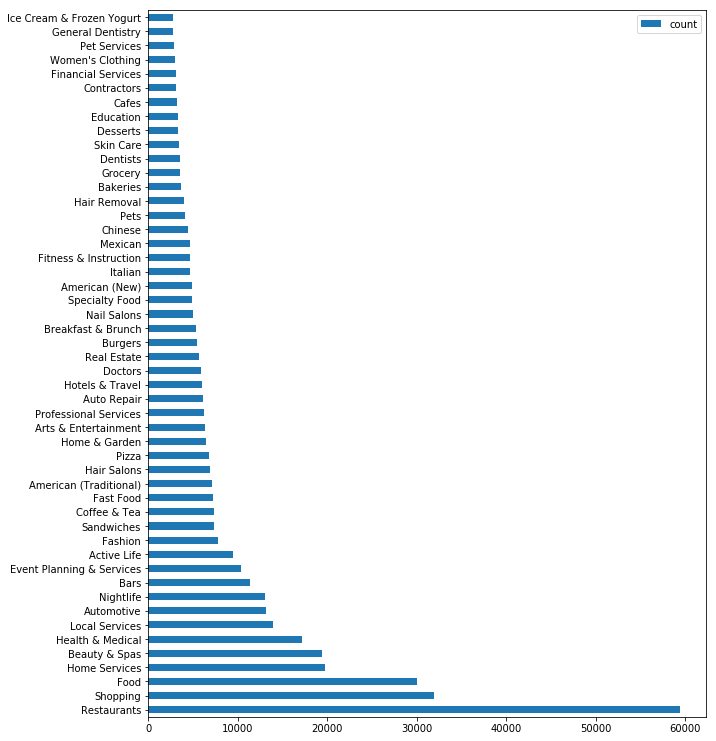

In [42]:
count_df.head(50).plot.barh(y='count', figsize=(10,13))
# plt.xticks(rotation=60)

In [82]:
# not all restaurants contain the word "Restaurant"
# we want to include all food related businesses

food_df = (business_df[
    (business_df['categories'].str.contains('Food',na=False)) |
     (business_df['categories'].str.contains('Restaurant',na=False))|
     (business_df['categories'].str.contains('Bar',na=False))
])

food_count_df = count_categories(food_df['categories_list'])

In [83]:
not_food_df = (business_df[
    (~business_df['categories'].str.contains('Food',na=False)) &
     (~business_df['categories'].str.contains('Restaurant',na=False))&
     (~business_df['categories'].str.contains('Bar',na=False))
])
not_food_count_df = count_categories(not_food_df['categories_list'])

In [ ]:
# check the non food categories to make sure there is no food related categories msising

not_food_count_df[75:]

In [85]:
len(food_df)

79545

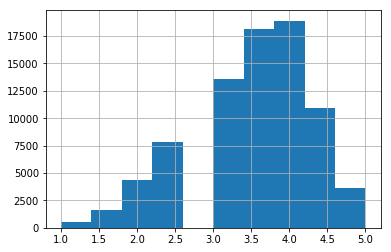

In [84]:
food_df['stars'].hist()

In [95]:
food_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,categories_list
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"[Specialty Food, Restaurants, Dim Sum, Impo..."
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"[Sushi Bars, Restaurants, Japanese]"
7,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV,"[Hair Salons, Hair Stylists, Barbers, Men's..."
11,2450 E Indian School Rd,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ,"[Restaurants, Breakfast & Brunch, Mexican, ..."
12,"119 Landings Dr, Ste 101","{'BusinessParking': ""{'garage': False, 'street...",5t3KVdMnFgAYmSl1wYLhmA,"Bars, Nightlife, Pubs, Barbers, Beauty & Spas,...",Mooresville,"{'Monday': '10:0-1:0', 'Tuesday': '10:0-1:0', ...",1,35.527410,-80.868003,The Kilted Buffalo Langtree,28117,9,3.5,NC,"[Bars, Nightlife, Pubs, Barbers, Beauty & ..."


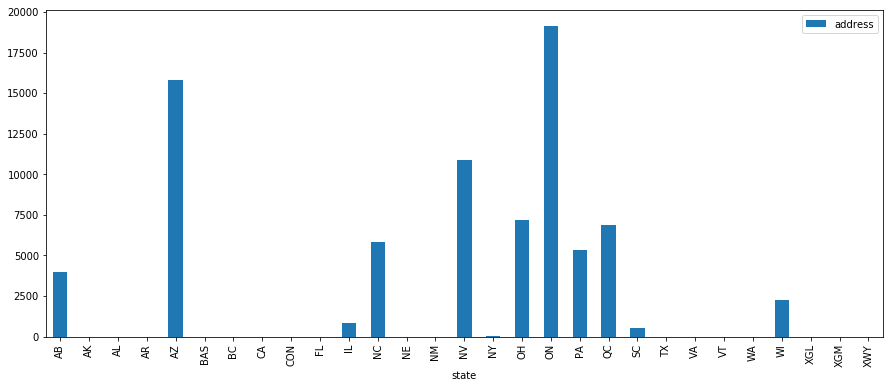

In [111]:
food_df.groupby('state').count().plot.bar(y='address', figsize=(15,6))

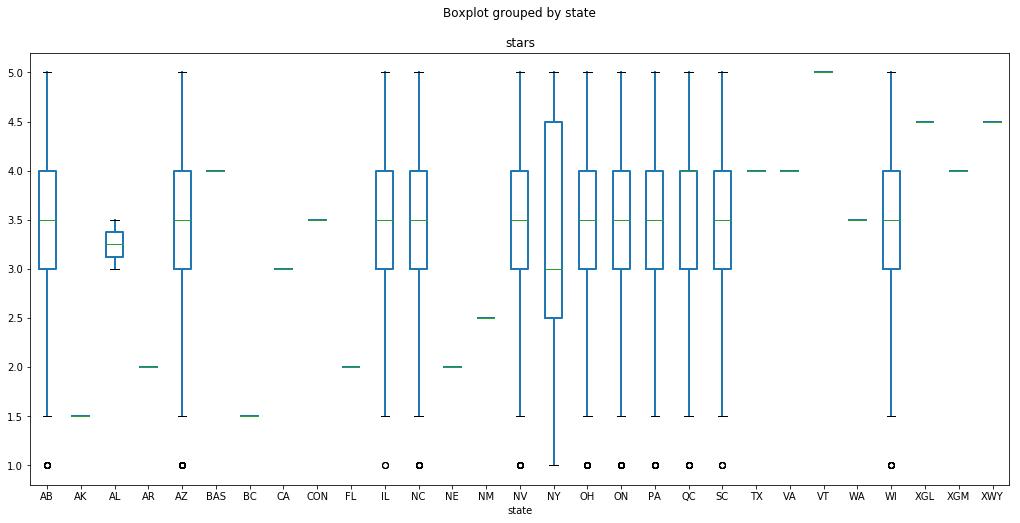

In [106]:
# df.boxplot(boxprops= dict(linewidth=1.0, color='black')
# , whiskerprops=dict(linestyle='-',linewidth=1.0, color='black'))

food_df.boxplot(column='stars', by='state', figsize=(17,8),
                boxprops=dict(linewidth=2.0, color='black'),
                whiskerprops=dict(linestyle='-',linewidth=2.0, color='black'),
                grid=False
               )
# (by='state',)

Most of the star distributions are very similar across states that have substantial number of observations.

### Available Attributes

In [176]:
count_att_df = count_categories(business_df['attributes'].values, 'dict')

In [179]:
business_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,categories_list
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ,"[Golf, Active Life]"
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"[Specialty Food, Restaurants, Dim Sum, Impo..."
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"[Sushi Bars, Restaurants, Japanese]"
3,"15655 W Roosevelt St, Ste 237",NaN,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ,"[Insurance, Financial Services]"
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC,"[Plumbing, Shopping, Local Services, Home S..."


## Tips dataset

In [181]:
len(tip_df)

1223094

In [183]:
len(tip_df['business_id'].unique())

123997

### Tips new columns

In [217]:
tip_df['text_len'] = tip_df['text'].apply(lambda x: len(x) if not pd.isnull(x) else 0 ,1)
tip_df['business_id_clean'] = tip_df['business_id'].apply(lambda x: x.strip())

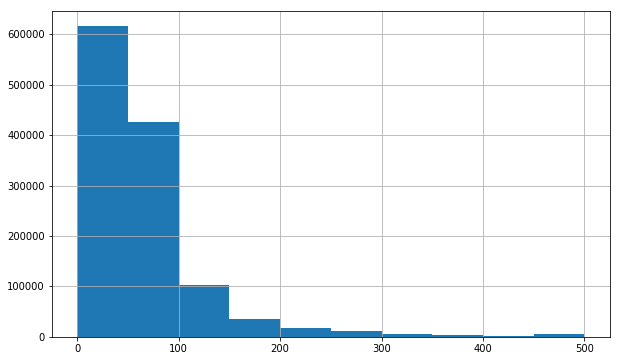

In [219]:
# text length histogram
tip_df['text_len'].hist(figsize=(10,6))

In [202]:
business_df[business_df['business_id'] =='--9e1ONYQuAa-CB_Rrw7Tw']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,categories_list
164075,3355 Las Vegas Blvd S,"{'WiFi': ""u'no'"", 'RestaurantsAttire': ""'dress...",--9e1ONYQuAa-CB_Rrw7Tw,"Cajun/Creole, Seafood, Steakhouses, Restaurants",Las Vegas,"{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",1,36.123183,-115.16919,Delmonico Steakhouse,89109,1613,4.0,NV,"[Cajun/Creole, Seafood, Steakhouses, Restau..."


In [201]:
tip_df[tip_df['business_id'] == '--9e1ONYQuAa-CB_Rrw7Tw']

,business_id,compliment_count,date,text,user_id,business_id_clean
27210,--9e1ONYQuAa-CB_Rrw7Tw,0,2014-06-27 01:37:27,Wine pairings for my prix fixe meal. Mmmm,LgFDWZTLi1w9OGi5BtKORg,--9e1ONYQuAa-CB_Rrw7Tw
53234,--9e1ONYQuAa-CB_Rrw7Tw,0,2016-12-19 00:29:11,*Currently closed (Dec 18 2016) for renovation...,q-v8elVPvKz0KvK69QSj1Q,--9e1ONYQuAa-CB_Rrw7Tw
53259,--9e1ONYQuAa-CB_Rrw7Tw,0,2015-11-04 21:54:20,They have great to go meals if you are working...,xBvDrnp8Kl45aXkuRTeRvA,--9e1ONYQuAa-CB_Rrw7Tw
53813,--9e1ONYQuAa-CB_Rrw7Tw,0,2012-05-20 01:38:10,"Lobster bisque, Ribeye, and a bottle of...",dNIWQmJOoU9ZD_3V7DGm6Q,--9e1ONYQuAa-CB_Rrw7Tw
55377,--9e1ONYQuAa-CB_Rrw7Tw,0,2012-10-15 06:12:50,Wonderful. Not stuffy. Service beyond reproach...,S6FLo7yVm-8A41jtSh-wnQ,--9e1ONYQuAa-CB_Rrw7Tw
60201,--9e1ONYQuAa-CB_Rrw7Tw,0,2012-05-20 01:45:47,Fourless chocolate cake !!!!!,HHxkcUhkbDc7Gaw8PK70lA,--9e1ONYQuAa-CB_Rrw7Tw
74694,--9e1ONYQuAa-CB_Rrw7Tw,0,2015-01-30 20:53:05,Reservations is a must.,3CGGvC-FAfo0AMwGVDrkNQ,--9e1ONYQuAa-CB_Rrw7Tw
82090,--9e1ONYQuAa-CB_Rrw7Tw,0,2012-02-03 13:07:06,Park by the palazzo,rSwiA7uSKAcsvrlantfStQ,--9e1ONYQuAa-CB_Rrw7Tw
95535,--9e1ONYQuAa-CB_Rrw7Tw,0,2014-07-27 18:01:56,Fancy-shmancy.... The food was really good. Pr...,ixM_wy2PTtgbiI95BQanSA,--9e1ONYQuAa-CB_Rrw7Tw
110461,--9e1ONYQuAa-CB_Rrw7Tw,0,2011-07-31 05:25:33,Steak is just so so. Rare = medium rare. Guess...,WEAHEaBfE8OsJH9baonatQ,--9e1ONYQuAa-CB_Rrw7Tw


In [213]:
print(len(set(business_df['business_id'])))
print(len(set(tip_df['business_id']))) # tip dataset does not contain all business ids from busines dataset
print(len(set(business_df['business_id']) & set(tip_df['business_id'].values)))

192609
123997
123997


In [212]:
# see how many reviews they have vs. tips 

(business_df.merge(
    tip_df.groupby('business_id', as_index=False).agg({'compliment_count': len}),
    left_on='business_id',
    right_on='business_id',
    how='inner'
))[['business_id', 'review_count', 'compliment_count']]

,business_id,review_count,compliment_count
0,1SWheh84yJXfytovILXOAQ,5,1
1,QXAEGFB4oINsVuTFxEYKFQ,128,22
2,gnKjwL_1w79qoiV3IC_xQQ,170,37
3,68dUKd8_8liJ7in4aWOSEA,3,1
4,5JucpCfHZltJh5r1JabjDg,7,1
5,Y6iyemLX_oylRpnr38vgMA,8,2
6,4GBVPIYRvzGh4K4TkRQ_rw,8,3
7,fcXOEZdXYeZqnQ3lGlOXmg,5,1
8,1Dfx3zM-rW4n-31KeC8sJg,18,5
9,5t3KVdMnFgAYmSl1wYLhmA,9,6


In [220]:
print(tip_df['date'].max())
print(tip_df['date'].min())

2018-11-15 08:39:36
2009-04-16 02:49:02


## User dataset

In [225]:
user_df.loc[0].T

average_stars                                                      4.03
compliment_cool                                                       1
compliment_cute                                                       0
compliment_funny                                                      1
compliment_hot                                                        2
compliment_list                                                       0
compliment_more                                                       0
compliment_note                                                       1
compliment_photos                                                     0
compliment_plain                                                      1
compliment_profile                                                    0
compliment_writer                                                     2
cool                                                                 25
elite                                                    2015,20

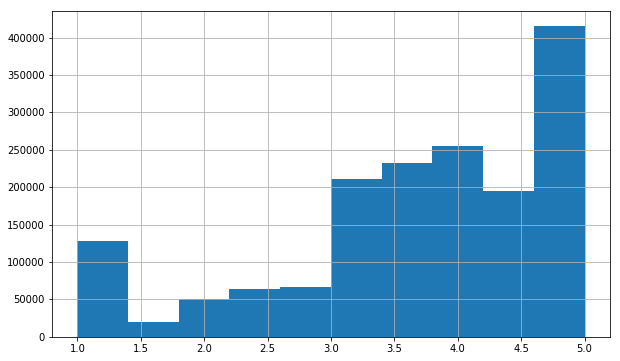

In [223]:
user_df['average_stars'].hist(figsize=(10,6))

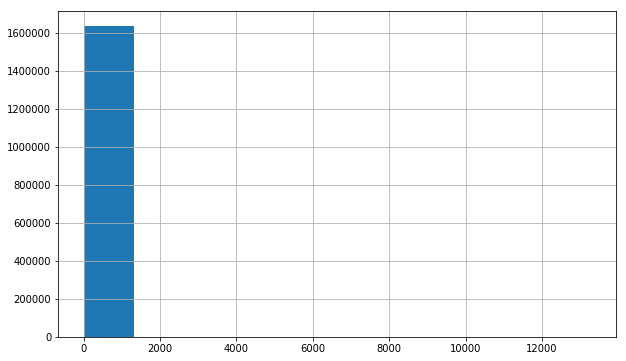

In [226]:
user_df['review_count'].hist(figsize=(10,6), )

Object `pd.plot.hist` not found.


## Photo Dataset

In [ ]:
photo_df.head()

In [ ]:
photo_df['label'].unique()

- Another reason for restaurant closure is high rent charges. Adding rent pricing per region could help explain more restaurant closures.
- A change in population demographics in certain areas of a city can increase or decrease traffic to some restaurants.

### Sources for yelp dataset problems:

https://towardsdatascience.com/using-yelp-data-to-predict-restaurant-closure-8aafa4f72ad6